In [22]:
#import all packages needed, define file import

import math

import networkx as nx

import geopandas as gpd

import json
from networkx.readwrite import json_graph

import gurobipy as gp
from gurobipy import GRB

from gerrychain import Graph

def read_graph_from_json(json_file):
    with open(json_file) as f:
        data = json.load(f)
    return json_graph.adjacency_graph(data) 

In [23]:
#import json
#from networkx.readwrite import json_graph
#
#def read_graph_from_json(json_file):
#    with open(json_file) as f:
#        data = json.load(f)
#    return json_graph.adjacency_graph(data) 

In [24]:
# Read Oklahoma county graph from the json file "OK_county.json"
#filepath = 'districting-data\\'
#filename = 'MT_county.json'

#G = read_graph_from_json( filename )

In [25]:
#read in the .shp and json file information for MT
shp_filename = 'MT_county.shp'
df = gpd.read_file( shp_filename ) 
json_filename = 'MT_county.json'
G = read_graph_from_json( json_filename )

##show nodes and verticies for visual confirmation
#print("The graph G_Montana contains:")
#print()
#print("The nodes:")
#print(G_Montana.nodes)
#print()
#print("And edges:")
#print(G_Montana.edges)

##prints, for each node of the graph, its node #, county name, and population
#
for node in G.nodes:
    county_name = G.nodes[node]['NAME20']
    county_population = G.nodes[node]['P0010001']
    G.nodes[node]['TOTPOP'] = county_population
#    print("Node",node,"represents",county_name,"County, pop:",county_population)

In [26]:
# we are to solve the following task:
# input: a population vector, desired number of districts k
# output: a partition of the populations into k districts (not necessarily connected!) 
#            to minimize the difference between most and least populated districts

import gurobipy as gp
from gurobipy import GRB

In [40]:
k = 2  # desired number of districts

# create model 
m = gp.Model()

# create variables
x = m.addVars( G.nodes, k, vtype=GRB.BINARY )  # x[i,j] = 1 when county i is assigned to district j
y = m.addVar()                                 # y = population of smallest district
z = m.addVar()                                 # z = population of largest district

In [41]:
# objective is to minimize absolute population deviation
m.setObjective( z - y, GRB.MINIMIZE )

# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum( x[i,j] for j in range(k) ) == 1 for i in G.nodes ) 

# add constraints saying that each district has population at least y
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) >= y for j in range(k) )

# add constraints saying that each district has population at most z
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) <= z for j in range(k) )

m.update()

In [42]:
# solve IP model
m.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 20.6.0 20G165)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 60 rows, 114 columns and 340 nonzeros
Model fingerprint: 0xaaf24e4c
Variable types: 2 continuous, 112 integer (112 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 279199.00000
Presolve removed 56 rows and 55 columns
Presolve time: 0.00s
Presolved: 4 rows, 59 columns, 63 nonzeros
Variable types: 0 continuous, 59 integer (56 binary)

Root relaxation: objective 5.000000e-01, 12 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.50000    0    2 279199.000    0.50000   100%    

In [43]:
# print the absolute population deviation
print("The minimum required deviation is",m.objVal,"persons.")

# retrieve the districts and their populations
districts = [ [ i for i in G.nodes if x[i,j].x > 0.5 ] for j in range(k) ]
district_county_names = [ [ G.nodes[i]['NAME20'] for i in district ] for district in districts ]
district_populations = [ sum( G.nodes[i]['TOTPOP'] for i in district ) for district in districts ]

# print district info
for j in range(k):
    print("District",j,"has these nodes =",districts[j],"and this population =",district_populations[j] )
    print("The corresponding county names are =",district_county_names[j] )
    print("")

The minimum required deviation is 1.0 persons.
District 0 has these nodes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 19, 22, 23, 24, 25, 29, 31, 32, 33, 36, 41, 42, 45, 46, 47, 49, 51, 53, 54] and this population = 542112
The corresponding county names are = ['Broadwater', 'Big Horn', 'Sanders', 'Lincoln', 'Granite', 'Custer', 'Richland', 'Wibaux', 'Golden Valley', 'Toole', 'Judith Basin', 'Powell', 'Park', 'Roosevelt', 'Fallon', 'Teton', 'Glacier', 'Lake', 'Hill', 'Treasure', 'Deer Lodge', 'Ravalli', 'Valley', 'Petroleum', 'Sheridan', 'Musselshell', 'Chouteau', 'Sweet Grass', 'Lewis and Clark', 'Pondera', 'Carter', 'Liberty', 'Cascade', 'Flathead']

District 1 has these nodes = [9, 11, 17, 18, 20, 21, 26, 27, 28, 30, 34, 35, 37, 38, 39, 40, 43, 44, 48, 50, 52, 55] and this population = 542113
The corresponding county names are = ['Carbon', 'Blaine', 'McCone', 'Stillwater', 'Dawson', 'Powder River', 'Mineral', 'Yellowstone', 'Jefferson', 'Wheatland', 'Phillips', 'Missoula', 

In [44]:
import networkx as nx
for district in districts:
    print("Is district =", district, "connected?", nx.is_connected( G.subgraph( district ) ) )

Is district = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 19, 22, 23, 24, 25, 29, 31, 32, 33, 36, 41, 42, 45, 46, 47, 49, 51, 53, 54] connected? False
Is district = [9, 11, 17, 18, 20, 21, 26, 27, 28, 30, 34, 35, 37, 38, 39, 40, 43, 44, 48, 50, 52, 55] connected? False


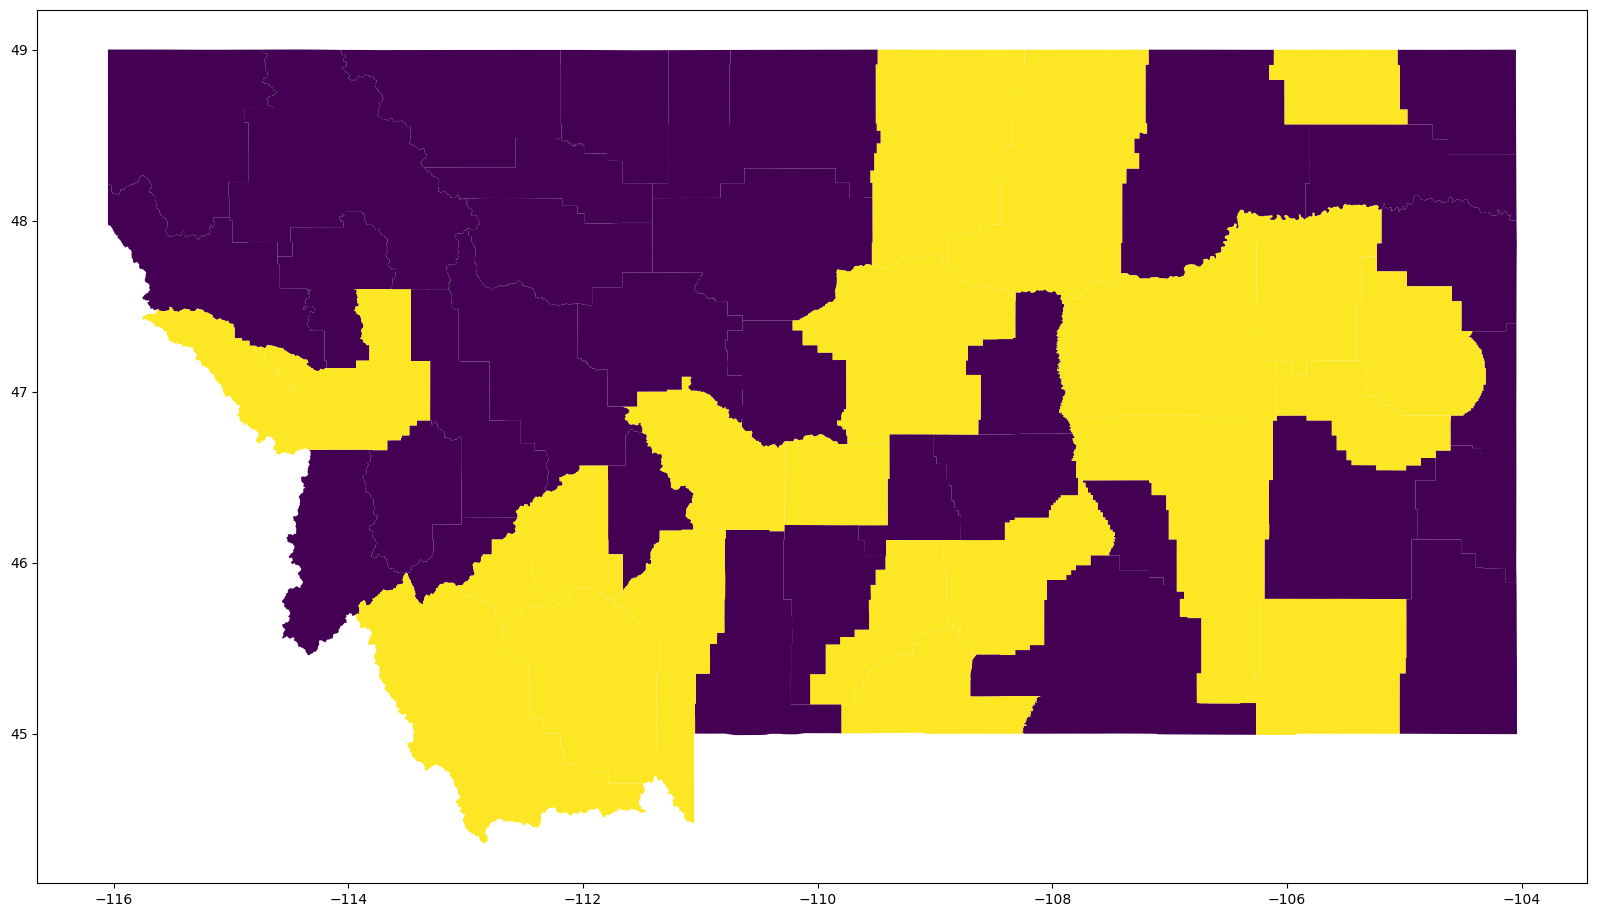

In [45]:

assignment = [ -1 for i in G.nodes ]
labeling = { i : j for i in G.nodes for j in range(k) if x[i,j].x > 0.5 }

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

# pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment',figsize=(20,30)).get_figure()